In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb, RandomEmbeddingEncoder
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks, evaluate_parametric_relation
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [3]:
model_run_name = "objrel_rndemb_DiT_B_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "RandomEmbeddingEncoder" 
suffix = ""
# /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndemb_DiT_B_pilot

### DiT network at float16, T5 at bfloat16

In [8]:
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, ) #subfolder="tokenizer")
if text_encoder_type == "T5":
    # T5_dtype = {"bfloat16": torch.bfloat16, "float16": torch.float16, "float32": torch.float32}[args.T5_dtype]
    T5_dtype = torch.bfloat16
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=T5_dtype, )
elif text_encoder_type == "RandomEmbeddingEncoder_wPosEmb":
    text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRel_pilot_rndemb/caption_feature_wmask'
    emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt")) 
    text_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                                emb_data["input_ids2dict_ids"], 
                                                emb_data["dict_ids2input_ids"], 
                                                max_seq_len=20, embed_dim=4096,
                                                wpe_scale=1/6).to("cuda")
elif text_encoder_type == "RandomEmbeddingEncoder":
    text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRel_pilot_rndemb/caption_feature_wmask'
    emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt")) 
    text_encoder = RandomEmbeddingEncoder(emb_data["embedding_dict"], 
                                                emb_data["input_ids2dict_ids"], 
                                                emb_data["dict_ids2input_ids"], 
                                                ).to("cuda")

/tmp/ipykernel_2931986/202818976.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))


In [4]:

# prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache_rndemb"
# # tokenizer = T5Tokenizer.from_pretrained(T5_path)
# rnd_encoding = th.load(join(text_feat_dir, "word_embedding_dict.pt"))
# rnd_text_encoder = RandomEmbeddingEncoder(rnd_encoding["embedding_dict"], rnd_encoding["input_ids2dict_ids"], rnd_encoding["dict_ids2input_ids"])

In [9]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/analysis_results/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )
# add attention map store hooks
# pipeline.transformer = replace_attn_processor(pipeline.transformer)
# attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
# attnvis_store.setup_hooks()
# torch.cuda.empty_cache()

2025-07-22 22:40:43,111 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_2931986/312608214.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

In [10]:
from utils.cv2_eval_utils import find_classify_objects, evaluate_parametric_relation, eval_func_factory, scene_info_collection

In [11]:
pipeline.to(device="cuda")

PixArtAlphaPipeline_custom {
  "_class_name": "PixArtAlphaPipeline_custom",
  "_diffusers_version": "0.35.0.dev0",
  "_name_or_path": "PixArt-alpha/PixArt-XL-2-512x512",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "transformer": [
    "diffusers",
    "Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

pipeline.text_encoder.dtype torch.float32
pipeline.transformer.dtype torch.float16
torch.Size([98, 120, 4096])
torch.Size([98, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

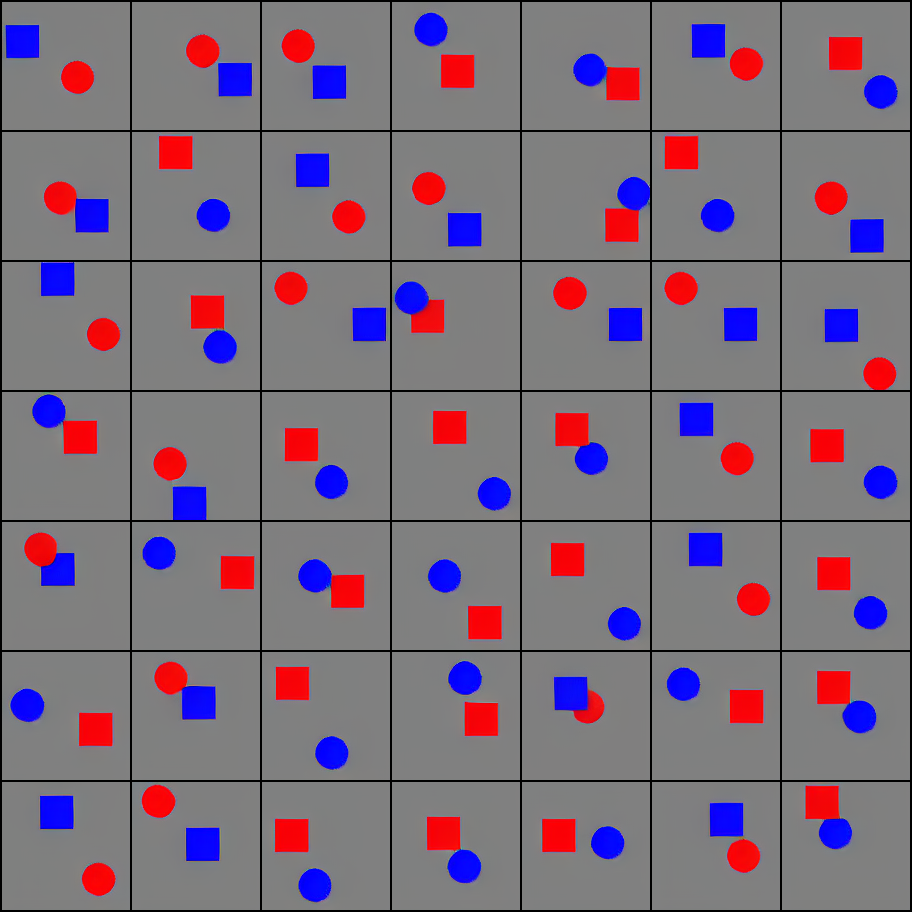

In [14]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
#%%
out = pipeline("blue square below and to the right of red circle", num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=49, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
pil_images_to_grid(out.images)

In [ ]:
scene_info_collection

{'blue_triangle_is_above_red_triangle': {'color1': 'blue',
  'shape1': 'Triangle',
  'color2': 'red',
  'shape2': 'Triangle',
  'spatial_relationship': 'above'},
 'blue_circle_is_above_and_to_the_right_of_blue_square': {'color1': 'blue',
  'shape1': 'Circle',
  'color2': 'blue',
  'shape2': 'Square',
  'spatial_relationship': 'upper_right'},
 'blue_circle_is_above_blue_square': {'color1': 'blue',
  'shape1': 'Circle',
  'color2': 'blue',
  'shape2': 'Square',
  'spatial_relationship': 'above'},
 'blue_square_is_to_the_right_of_red_circle': {'color1': 'blue',
  'shape1': 'Square',
  'color2': 'red',
  'shape2': 'Circle',
  'spatial_relationship': 'right'},
 'blue_triangle_is_to_the_upper_left_of_red_square': {'color1': 'blue',
  'shape1': 'Triangle',
  'color2': 'red',
  'shape2': 'Square',
  'spatial_relationship': 'upper_left'},
 'circle_is_below_red_square': {'color1': None,
  'shape1': 'Circle',
  'color2': 'red',
  'shape2': 'Square',
  'spatial_relationship': 'below'},
 'red_circl